TODO - add custom NLP pipeline in Spacy (move function to shared module)
Also wordcould or each alsbum
Compare with Tom Jones

In [1]:
import pandas as pd
import textacy
import spacy
import string
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from os import path
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np


nlp = spacy.load('en_core_web_lg')
% matplotlib inline

Load the 

In [2]:
lyrics = pd.read_csv("SFALyrics.csv", dtype=str)
lyrics = lyrics[['lyrics', 'title', 'album']]
lyrics = lyrics[pd.notnull(lyrics['title'])]
lyrics.loc[lyrics['album'] == 'Dark Day/Light Years', 'album'] = 'Dark Days/Light Years'
lyrics.loc[lyrics['album'] == 'Gorilla', 'album'] = 'Guerilla'
lyrics['metadata'] = '{"title": "' + lyrics['title'] + '" ,"album":"' + lyrics['album'] + '"}'

lyrics.head()

,lyrics,title,album,metadata
0,I had a soul transplant operation \nCoz my byp...,God! How me magic,Fuzzy Logic,"{""title"": ""God! How me magic"" ,""album"":""Fuzzy ..."
1,"[Bunf:] \nHamster, turnin' round in your wheel...",Fuzzy Birds,Fuzzy Logic,"{""title"": ""Fuzzy Birds"" ,""album"":""Fuzzy Logic""}"
2,"First time, I did it for the hell of it \nStuc...",Something 4 the weekend,Fuzzy Logic,"{""title"": ""Something 4 the weekend"" ,""album"":""..."
3,Locked in a sorry dream \nYou know we're drown...,Frisbee,Fuzzy Logic,"{""title"": ""Frisbee"" ,""album"":""Fuzzy Logic""}"
4,I was lost \nLost on the bypass road \nCould b...,Hometown Unicorm,Fuzzy Logic,"{""title"": ""Hometown Unicorm"" ,""album"":""Fuzzy L..."


## Pre-process text

In [6]:
lyrics['Line'] = lyrics['lyrics'].apply(nlp)
lyrics.head()

,lyrics,title,album,metadata,Line
0,I had a soul transplant operation \nCoz my byp...,God! How me magic,Fuzzy Logic,"{""title"": ""God! How me magic"" ,""album"":""Fuzzy ...","(I, had, a, soul, transplant, operation, \n, C..."
1,"[Bunf:] \nHamster, turnin' round in your wheel...",Fuzzy Birds,Fuzzy Logic,"{""title"": ""Fuzzy Birds"" ,""album"":""Fuzzy Logic""}","([, Bunf, :, ], \n, Hamster, ,, turnin, ', rou..."
2,"First time, I did it for the hell of it \nStuc...",Something 4 the weekend,Fuzzy Logic,"{""title"": ""Something 4 the weekend"" ,""album"":""...","(First, time, ,, I, did, it, for, the, hell, o..."
3,Locked in a sorry dream \nYou know we're drown...,Frisbee,Fuzzy Logic,"{""title"": ""Frisbee"" ,""album"":""Fuzzy Logic""}","(Locked, in, a, sorry, dream, \n, You, know, w..."
4,I was lost \nLost on the bypass road \nCould b...,Hometown Unicorm,Fuzzy Logic,"{""title"": ""Hometown Unicorm"" ,""album"":""Fuzzy L...","(I, was, lost, \n, Lost, on, the, bypass, road..."


## Create a corpus
A corpus is an ordered collection of textacy.Docs, all processed by the same spacy language pipeline.

In [13]:
corpus = textacy.Corpus(nlp, docs=list(lyrics['Line']), metadatas= list(lyrics['metadata']))
#corpus = textacy.Corpus(nlp, texts=list(lyrics['Line']), metadatas= list(lyrics['metadata']))

In [278]:
print("This corpus has {} documents, {} sentances and {} tokens".format(corpus.n_docs, corpus.n_sents, corpus.n_tokens))

This corpus has 83 documents, 755 sentances and 9520 tokens


### Usuing Corpus we can still access details about each doument
Each document is a song, so lets get the details from each, usuing the lyrics themselves and any metadata.
The metatdata is stored as a dict string - or json - so needs to be intepretted

In [16]:
import json
n = 45
doc = corpus[n]
d = json.loads(doc.metadata.replace("'", "\""))
ts = textacy.TextStats(doc)
print("{} from the album {} has {} unique words".format(d['title'], d['album'], ts.n_unique_words))

Liberty Belle from the album Phantom Power has 101 unique words


In [17]:
vectorizer = textacy.Vectorizer(
    tf_type='linear', apply_idf=True, idf_type='smooth', norm='l2',
    min_df=2, max_df=0.95)

In [18]:
doc_term_matrix = vectorizer.fit_transform(
    (doc.to_terms_list(ngrams=1, named_entities=True, as_strings=True)
        for doc in corpus))

print(repr(doc_term_matrix))

<83x627 sparse matrix of type '<class 'numpy.float64'>'
	with 3740 stored elements in Compressed Sparse Row format>


In [19]:
model = textacy.tm.TopicModel('nmf', n_topics=5)
model.fit(doc_term_matrix)
model

TopicModel(n_topics=5, model=NMF)

In [20]:
doc_topic_matrix = model.transform(doc_term_matrix)
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term):
     print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : the   be   to   and   a   in   not   of   do   that
topic 1 : la   long   go   school   door   to   house   home   space   just
topic 2 : baby   bye   sky   try   ball   eat   yeah   or   if   die
topic 3 : show   hand   now   jump   god   off   mad   roll   on   records
topic 4 : phone   get   have   heart   fire   a   for   lay   brain   in


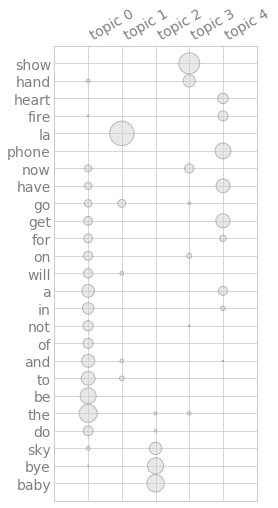

In [21]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term,
                   topics=-1,  n_terms=25, sort_terms_by='seriation')

## Generate a word cloud for each album

In [286]:
# split the 

albums = dict(tuple(lyrics.groupby('album')))

print (albums['Fuzzy Logic'])

                                               lyrics  \
0   I had a soul transplant operation \nCoz my byp...   
1   [Bunf:] \nHamster, turnin' round in your wheel...   
2   First time, I did it for the hell of it \nStuc...   
3   Locked in a sorry dream \nYou know we're drown...   
4   I was lost \nLost on the bypass road \nCould b...   
5   Lost capacity \nFor infinity \nYou and me are ...   
6   If you don't want me to destroy you \nTake a l...   
7   Bad! Bad! Bad! Bad! Behaviour Bad! Bad! Bad! B...   
8   The blim holes in my shell suit \nJoined into ...   
9   You and me \nAnd the guy from the Sparks \nHan...   
10  Long gone \nOoo ooo ooo ooo ooo \nLong gone \n...   
11  It's been a funny kind of day \nSîan Lloyd say...   

                                   title        album  \
0                      God! How me magic  Fuzzy Logic   
1                            Fuzzy Birds  Fuzzy Logic   
2                Something 4 the weekend  Fuzzy Logic   
3                             